In [1]:
import numpy as np
import pandas as pd

import re
import folium
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action = 'ignore')

In [2]:
# 1.에서 만든 데이터셋 불러오기

df = pd.read_csv('final_dataset.csv')
print(df.shape)
df.head()

(308, 28)


,lonlat,location,academy,busstation,CCTV,childcarelibrary,childrencenter,crosswalk,elementary,emergencyroom,...,infant,park,police,publicparking,chiancenter,seniorcenter,oldwelfare,taxistop,trashcan,subway
0,lon15_lat1,all,0.0,0.0,19.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,2.0,0.0,0.0,2.0,0.0,1.0,0.0
1,lon16_lat1,all,0.0,4.0,18.0,3.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0
2,lon17_lat1,all,0.0,3.0,21.0,3.0,0.0,0.0,1.0,0.0,...,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,lon18_lat1,all,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,lon15_lat2,all,0.0,6.0,28.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,5.0,0.0,1.0,2.0,0.0,3.0,0.0


# MinMaxScaler로 모든 값 정규화

In [3]:
# Scale할 데이터만 따로 추출

MMS_df = df[df.columns.difference(['lonlat','location'])]

In [4]:
# MinMaxScaler

from sklearn.preprocessing import MinMaxScaler

MMS = MinMaxScaler()
MMS_scaled = MMS.fit_transform(MMS_df)

In [5]:
# scale된 데이터(arary) → 원래대로 데이터프레임으로 

MMS_scaled_df = pd.DataFrame(MMS_scaled)
MMS_scaled_df.columns = MMS_df.columns

In [6]:
df = pd.concat([df[['lonlat','location']], MMS_scaled_df], axis = 1)
df.head()

,lonlat,location,CCTV,academy,busstation,chiancenter,childcarelibrary,childrencenter,crosswalk,elementary,...,lifelongedu,middle,oldwelfare,park,police,publicparking,seniorcenter,subway,taxistop,trashcan
0,lon15_lat1,all,0.413043,0.0,0.000000,0.0,0.333333,0.0,0.0,0.000000,...,0.259259,0.000000,0.666667,0.0,0.333333,0.250,0.000,0.0,0.0,0.166667
1,lon16_lat1,all,0.391304,0.0,0.266667,0.0,0.333333,0.0,0.5,0.166667,...,0.259259,0.000000,0.666667,0.0,0.333333,0.250,0.000,0.0,0.0,0.000000
2,lon17_lat1,all,0.456522,0.0,0.200000,0.0,0.333333,0.0,0.0,0.166667,...,0.370370,0.000000,0.333333,0.0,0.666667,0.125,0.000,0.0,0.0,0.000000
3,lon18_lat1,all,0.000000,0.0,0.066667,0.0,0.111111,0.0,0.0,0.166667,...,0.148148,0.000000,0.333333,0.0,0.333333,0.125,0.000,0.0,0.0,0.000000
4,lon15_lat2,all,0.608696,0.0,0.400000,0.0,0.333333,0.0,0.0,0.000000,...,0.296296,0.142857,0.666667,0.0,0.333333,0.625,0.125,0.0,0.0,0.500000


In [7]:
# 카테고리 나누기

traffic = ['busstation','taxistop','subway']
education = ['academy','elementary','high','kindergarden','lifelongedu','middle']
welfare = ['childcarelibrary','childrencenter','library','infant','park',
           'seniorcenter','oldwelfare','hospital','publicparking','trashcan']
safety = ['CCTV','crosswalk','emergencyroom','femalezone','firestation','police','chiancenter']

# 가중치

score = [2,1,3,2,3,3,3,2,3,3,3,3,3,3,3,3,3,2,1,2,1,3,1,3,3,3]

In [8]:
scoredf = pd.DataFrame({'facilities':traffic + education + welfare + safety, 'score': score})

## 카테고리별 점수 만들기

카테고리별 점수(score) = ∑(특성점수 * 특성가중치) / (특성 개수)

* 특성가중치: 1,2,3등급의 시설물을 나누어 각각 3,2,1점씩 부여

total_score = 4개 카테고리 점수의 평균

In [9]:
# 카테고리별 점수 만들기

traffic_score = []
for i in range(df.shape[0]):
    score = 0
    for n,m in zip(df.iloc[i][traffic], scoredf.loc[pd.Series([i in traffic for i in  scoredf['facilities']])]['score']):
        score += (n * m)
    traffic_score.append(score / len(traffic))
        
education_score = []
for i in range(df.shape[0]):
    score = 0
    for n,m in zip(df.iloc[i][education], scoredf.loc[pd.Series([i in education for i in  scoredf['facilities']])]['score']):
        score += (n * m)
    education_score.append(score / len(education))
        
welfare_score = []
for i in range(df.shape[0]):
    score = 0
    for n,m in zip(df.iloc[i][welfare], scoredf.loc[pd.Series([i in welfare for i in  scoredf['facilities']])]['score']):
        score += (n * m)
    welfare_score.append(score / len(welfare))
    
safety_score = []
for i in range(df.shape[0]):
    score = 0
    for n,m in zip(df.iloc[i][safety], scoredf.loc[pd.Series([i in safety for i in  scoredf['facilities']])]['score']):
        score += (n * m)
    safety_score.append(score / len(safety))      

In [10]:
df['traffic_score'] = traffic_score
df['education_score'] = education_score
df['welfare_score'] = welfare_score
df['safety_score'] = safety_score

df['total_score'] = (df['traffic_score'] + df['education_score'] + df['welfare_score'] + df['safety_score']) / 4

In [11]:
# df.to_csv('scoredf.csv', index = False)

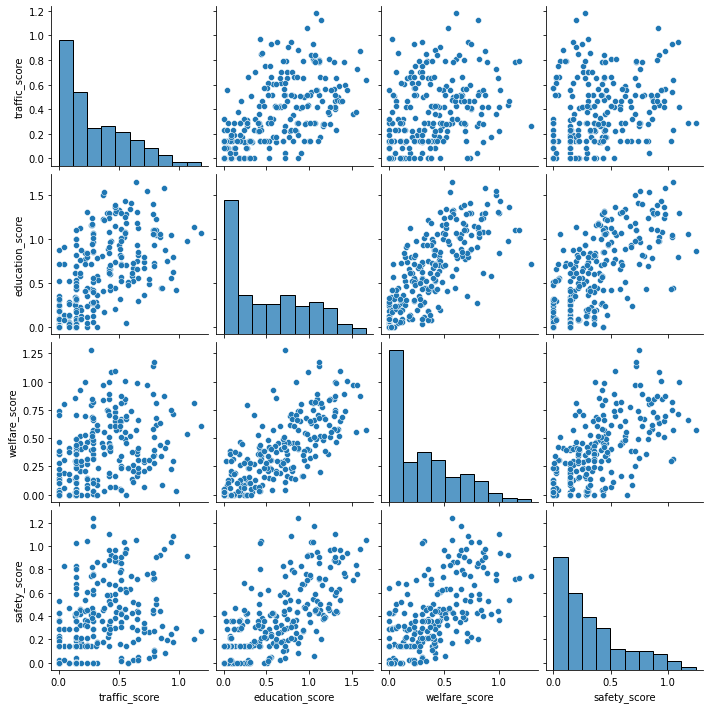

In [12]:
import seaborn as sns

score_df = df[['traffic_score','education_score','welfare_score','safety_score']]
sns.pairplot(score_df, diag_kind='hist')
plt.show()

In [77]:
# education, welfare, safety는 서로 약간 선형을 띄는 경향
# 나머지는 패턴X